<a href="https://colab.research.google.com/github/taji99/python_basic/blob/master/200729_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAEの実装
VAE（変分自己符号器）を実装します。
VAEにより、連続的に変化する手書き文字の画像を生成しましょう。

## 訓練用データの用意
VAEに用いる訓練用のデータを用意します。  
MNIST（手書き文字）のデータを読み込み、表示します。

Using TensorFlow backend.


11493376/11490434 [==============================] - 2s 0us/step
(60000, 28, 28) (10000, 28, 28)


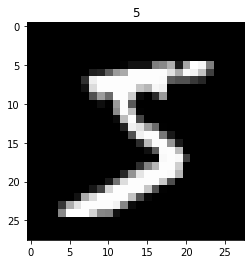

(60000, 784) (10000, 784)


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from keras.datasets import mnist

(x_train, t_train), (x_test, t_test) = mnist.load_data()  # MNISTの読み込み
print(x_train.shape, x_test.shape)  # 28x28の手書き文字画像が6万枚

# 各ピクセルの値を0-1の範囲に収める
x_train = x_train / 255
x_test = x_test / 255

# 手書き文字画像の表示
plt.imshow(x_train[0].reshape(28, 28), cmap="gray")
plt.title(t_train[0])
plt.show() 

# 一次元に変換する
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
print(x_train.shape, x_test.shape)

## VAEの各設定
VAEに必要な各設定を行います。

In [2]:
epochs = 10  
batch_size = 128
n_in_out = 784  # 入出力層のニューロン数
n_z = 2  # 潜在変数の数（次元数）
n_mid = 256  # 中間層のニューロン数

 ## モデルの構築
 KerasによりVAEのモデルを構築します。  
 Encoderの出力は、潜在変数の平均値$\mu$および、標準偏差$\sigma$の2乗（=分散）の対数とします。  
 出力に標準偏差ではなく分散の対数を使うことで、出力範囲が狭くても広い範囲の標準偏差を表すことができます。   
   
VAEのコードでは、バックプロパゲーションによる学習のためにReparametrization Trickが使われます。    
平均値0標準偏差1のノイズεを発生させて、標準偏差$\sigma$とかけて平均値$\mu$に加えることで、潜在変数$z$とします。  
$$\epsilon \sim N(0,\, I)$$
$$z=\mu + \epsilon\odot\sigma$$
  
損失関数についてですが、以下の式で表される項は出力がどれだけ入力を再現できているかを表します。  
$$\frac{1}{L}\sum_{i=1}^{L}\sum_{j=1}^{D}x_{ij}\log y_{ij}+(1-x_{ij})log(1-y_{ij})$$
$L$:バッチサイズ、￼$D$:入力層のニューロン数、￼$x_{ij}$: VAEの入力、$y_{ij}$: VAEの出力   
また、以下の式で表される項は、平均値が0に、標準偏差が1に近づくように機能します。  
$$\frac{1}{2}\sum_{k=1}^{J}(1+\log \sigma_k^2 - \mu_k^2 - \sigma_k^2)$$  
$J$: 潜在変数の次元数  
VAEでは、これらの項の和を損失関数として使用します。

In [3]:
from keras.models import Model
from keras import metrics  # 評価関数
from keras.layers import Input, Dense, Lambda
from keras import backend as K  # 乱数の発生に使用

# 潜在変数をサンプリングするための関数
def z_sample(args):
    mu, log_var = args  # 潜在変数の平均値と、分散の対数
    epsilon = K.random_normal(shape=K.shape(log_var), mean=0, stddev=1)
    return mu + epsilon * K.exp(log_var / 2)  # Reparametrization Trickにより潜在変数を求める

# VAEのネットワーク構築
x = Input(shape=(n_in_out,))
h_encoder = Dense(n_mid, activation="relu")(x)

mu = Dense(n_z)(h_encoder)
log_var = Dense(n_z)(h_encoder)
z = Lambda(z_sample, output_shape=(n_z,))([mu, log_var])

mid_decoder = Dense(n_mid, activation="relu")  # 後で使用
h_decoder = mid_decoder(z)
out_decoder = Dense(n_in_out, activation="sigmoid")  # 後で使用
y = out_decoder(h_decoder)

# VAEのモデルを生成
model_vae = Model(x, y)

# 損失関数
rec_loss = n_in_out * metrics.binary_crossentropy(x, y)
reg_loss = - 0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
vae_loss = K.mean(rec_loss + reg_loss)

model_vae.add_loss(vae_loss)
model_vae.compile(optimizer="rmsprop")
model_vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_5 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_5.
  'be expecting any data to be passed to {0}.'.format(name))


## 学習
構築したVAEのモデルを使って、学習を行います。  
入力を再現するように学習するので、正解は必要ありません。

In [4]:
model_vae.fit(x_train,
              shuffle=True,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 112us/step - loss: 195.0996 - val_loss: 173.0453
Epoch 2/10
60000/60000 [==============================] - 6s 107us/step - loss: 170.6447 - val_loss: 168.3671
Epoch 3/10
60000/60000 [==============================] - 6s 104us/step - loss: 167.4107 - val_loss: 166.5160
Epoch 4/10
60000/60000 [==============================] - 6s 107us/step - loss: 165.3461 - val_loss: 164.7689
Epoch 5/10
60000/60000 [==============================] - 6s 107us/step - loss: 163.7149 - val_loss: 163.3655
Epoch 6/10
60000/60000 [==============================] - 6s 106us/step - loss: 162.4428 - val_loss: 162.0552
Epoch 7/10
60000/60000 [==============================] - 6s 105us/step - loss: 161.3001 - val_loss: 161.1464
Epoch 8/10
60000/60000 [==============================] - 6s 107us/step - loss: 160.2871 - val_loss: 159.9676
Epoch 9/10
60000/60000 [==============================] - 6s 108us/ste

## 潜在空間の可視化
潜在変数を平面にプロットし、潜在空間を可視化します。  

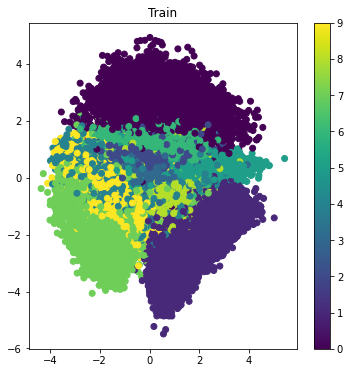

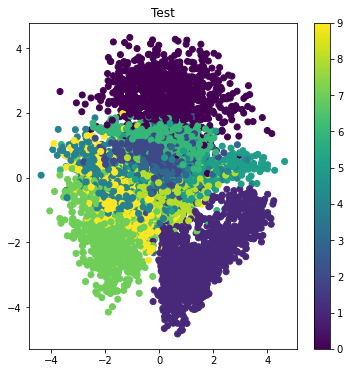

In [5]:
# 潜在変数を得るためのモデル
encoder = Model(x, z)

# 訓練データから作った潜在変数を2次元プロット
z_train = encoder.predict(x_train, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_train[:, 0], z_train[:, 1], c=t_train)  # ラベルを色で表す
plt.title("Train")
plt.colorbar()
plt.show()

# テストデータを入力して潜在空間に2次元プロットする 正解ラベルを色で表示
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=t_test)
plt.title("Test")
plt.colorbar()
plt.show()

訓練データ、テストデータともに、
同じような領域に各数字の潜在変数が分布していることが確認できます。

## 画像の生成
訓練済みのVAEを使って、画像を生成します。  
潜在変数を連続的に変化させて、生成される画像がどのように変化するのかを確認します。

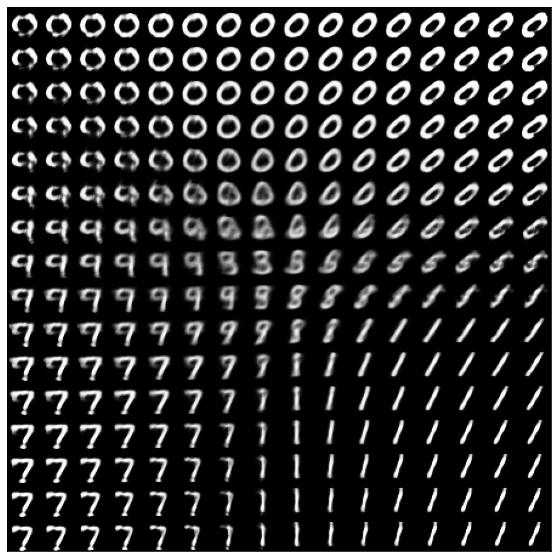

In [6]:
# 画像の生成器
input_decoder = Input(shape=(n_z,))
h_decoder = mid_decoder(input_decoder)
y = out_decoder(h_decoder)
generator = Model(input_decoder, y)

# 画像を並べる設定
n = 16  # 手書き文字画像を16x16並べる
image_size = 28
matrix_image = np.zeros((image_size*n, image_size*n))  # 全体の画像

# 潜在変数
z_1 = np.linspace(5, -5, n)  # 各行
z_2 = np.linspace(-5, 5, n)  # 各列

#  潜在変数を変化させて画像を生成
for i, z1 in enumerate(z_1):
    for j, z2 in enumerate(z_2):
        decoded = generator.predict(np.array([[z2, z1]]))  # x軸、y軸の順に入れる
        image = decoded[0].reshape(image_size, image_size)
        matrix_image[i*image_size : (i+1)*image_size, j*image_size: (j+1)*image_size] = image

plt.figure(figsize=(10, 10))
plt.imshow(matrix_image, cmap="Greys_r")
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # 軸目盛りのラベルと線を消す
plt.show()